See 'swallow classification bandpass.ipynb' for preprocessing.

In [1]:
import os
import pandas as pd
import random
import shutil

data_path = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\data\07_18_25\extracted signals'
class_folders = os.listdir(data_path)

# Feature Extraction
I got some of these features and functions from this link: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

In [2]:
import numpy as np

# mean absolute value
def mav(data):
    return np.mean(np.abs(data), axis=0)

# root mean square
def rms(data):
    return np.sqrt(np.mean(data**2,axis=0))  
    
# wavelength
def wavelength(data):
    return np.sum(np.abs(np.diff(data)), axis=0)
    
# zero crossing rate
def zcr(data):
    return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0) / (len(data)-1)

# variance
def var(data):
    return np.var(data, axis=0)

# sum of absolute differences between consecutive samples
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

# mean frequency
def mean_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    return np.sum(freqs * spectrum) / np.sum(spectrum)

# median frequency
def median_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    cumulative = np.cumsum(spectrum)
    total = cumulative[-1]
    med_idx = np.searchsorted(cumulative, total / 2)
    return freqs[med_idx]

# peak frequency
def peak_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    peak_idx = np.argmax(spectrum)
    return freqs[peak_idx]

# shannon entropy
def shannon_entropy(signal, num_bins=30):
    hist, bin_edges = np.histogram(signal, bins=num_bins, density=True)
    prob = hist * np.diff(bin_edges)  

    prob = prob[prob > 0]

    entropy = -np.sum(prob * np.log2(prob))
    return entropy

# integrated emg
def iemg(signal):
    return np.sum(np.abs(signal))

In [3]:
df = pd.DataFrame()

class_map = {}
i = 0

exclude = ['oral prep 0', 'grape']

for class_name in os.listdir(data_path):
    if class_name in exclude:
        continue
        
    class_path = os.path.join(data_path, class_name)
    class_str = class_name.rstrip('.txt')
    parts = class_str.split()
    volume = parts[-1]
    substance = ' '.join(parts[:-1])
    
    for sample_name in os.listdir(class_path):
        sample_df = pd.read_csv(os.path.join(data_path, class_name, sample_name), delimiter = ",", header = None)
        
        sample_df.columns = [i+1 for i in range(sample_df.shape[1])]
        if substance not in class_map:
            class_map[substance] = i
            i += 1
        
        sample_df['substance'] = substance
        sample_df['volume'] = volume
        sample_df_grouped = sample_df.groupby(['substance', 'volume'])
        
        features_df = sample_df_grouped.agg(['max', mav, rms, wavelength, zcr, var, abs_diffs_signal, mean_freq, median_freq, peak_freq, shannon_entropy, iemg])
        df = pd.concat([df, features_df])

df.reset_index(inplace=True)
df

substance volume         1                                                \
                           max        mav        rms    wavelength       zcr   
0       apple     10   73.5244  10.123081  15.526914   8511.370464  0.271271   
1       apple     10   86.1073   9.896790  16.791919   8262.519721  0.290290   
2       apple     10   84.7438  10.532140  16.572327   8938.223938  0.274274   
3       apple     10  125.6940  11.846242  20.842131   9634.231501  0.250250   
4       apple     10   84.5021  11.854229  18.994828   9543.440074  0.257257   
..        ...    ...       ...        ...        ...           ...       ...   
318    yogurt     20   69.5755  10.175371  15.426147   8874.451929  0.279279   
319    yogurt     20   74.0248  11.288252  18.020237   9792.563997  0.273273   
320    yogurt     20   91.9620  11.081596  17.163182   8838.968969  0.254254   
321    yogurt     20   61.4933  11.031382  16.758005   9634.328738  0.288288   
322    yogurt     20   91.9919  13.782139  20.737838  11234.928474  0.265265   

                                             ...           22             \
            var abs_diffs_signal  mean_freq  ...          rms wavelength   
0    241.085047      8511.370464  67.493364  ...  4634.416598     426580   
1    281.968302      8262.519721  64.960675  ...  4996.715521     449540   
2    274.641479      8938.223938  69.765386  ...  5597.687773     391580   
3    434.394440      9634.231501  62.981642  ...  6691.171078     458780   
4    360.801618      9543.440074  63.408721  ...  6675.993619     353780   
..          ...              ...        ...  ...          ...        ...   
318  237.965865      8874.451929  69.720942  ...  4313.488379     329560   
319  324.728936      9792.563997  70.751609  ...  5367.578821     396620   
320  294.572930      8838.968969  64.957040  ...  5302.465577     390740   
321  280.830702      9634.328738  68.141730  ...  5118.934928     390040   
322  430.057924     11234.928474  64.259121  ...  4801.379552     462560   

                                                                              \
          zcr           var abs_diffs_signal mean_freq median_freq peak_freq   
0    0.067067  2.147730e+07           426580  6.866916         4.0       2.5   
1    0.040040  2.476357e+07           449540  5.226880         1.5       1.5   
2    0.036036  3.078873e+07           391580  3.448059         1.0       0.5   
3    0.031031  4.119861e+07           458780  4.439223         1.0       0.5   
4    0.026026  4.449073e+07           353780  2.640694         1.0       0.5   
..        ...           ...              ...       ...         ...       ...   
318  0.043043  1.854732e+07           329560  6.230145         3.5       2.5   
319  0.036036  2.879051e+07           396620  5.266034         2.5       2.0   
320  0.035035  2.811149e+07           390740  4.882148         3.0       2.5   
321  0.047047  2.616131e+07           390040  5.639875         3.5       2.5   
322  0.058058  2.290177e+07           462560  6.510082         4.0       2.5   

                              
    shannon_entropy     iemg  
0          4.040291  3322060  
1          4.537548  4038860  
2          4.487950  4577860  
3          4.410476  5437880  
4          4.641191  5531540  
..              ...      ...  
318        3.997013  3136980  
319        4.062512  3865400  
320        4.641988  4293940  
321        4.344892  3813460  
322        4.518855  3783080  

[323 rows x 266 columns]

In [4]:
print(class_map)

{'apple': 0, 'dry swallow': 1, 'jelly': 2, 'milk': 3, 'redu oral prep': 4, 'water': 5, 'yogurt': 6}


In [5]:
df['substance'] = df['substance'].map(class_map)

# Configuration Classification

In [6]:
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

svm_model = svm.SVC(kernel='linear', random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)
dt_model = DecisionTreeClassifier(random_state=42)
nb_model = GaussianNB()
regression_model = LogisticRegression(max_iter=500, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

In [7]:
from sklearn.multioutput import MultiOutputClassifier

svm_multioutput = MultiOutputClassifier(svm_model)
knn_multioutput = MultiOutputClassifier(knn_model)
dt_multioutput = MultiOutputClassifier(dt_model)
nb_multioutput = MultiOutputClassifier(nb_model)
regression_multioutput = MultiOutputClassifier(regression_model)
gb_multioutput = MultiOutputClassifier(gb_model)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

models = [svm_multioutput, knn_multioutput, dt_multioutput, nb_multioutput, regression_multioutput, gb_multioutput]
model_names = ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes', 'Logistic Regression', 'Gradient Boost']
label_names = ['Substance', 'Volume']
imu_channels = [17, 18, 19, 20, 21, 22]

imu_acc_df = pd.read_csv('imu_accuracies.csv', header=None)
imu_acc = imu_acc_df.iloc[0].tolist()

def train_models(x, y, cm):
    acc = []
    per_label_acc = []

    x_train, x_test, y_train, y_test = make_split(x, y)
    
    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
    
        # Exact match accuracy (all labels correct)
        exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))
    
        # Per-label accuracy
        per_label_accuracy = (y_test == y_pred).mean(axis=0)
    
        acc.append(exact_match_accuracy * 100)
        per_label_acc.append(per_label_accuracy * 100)

        # Confusion matrices for each label
        if cm:
            for i, col in enumerate(y_test.columns):
                cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
                plt.figure(figsize=(4, 3))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'{model_names[models.index(model)]} Confusion Matrix, {label_names[i]}')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.show()

    return acc, per_label_acc

def make_split(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    return x_train_scaled, x_test_scaled, y_train, y_test

def print_metrics(exact_acc, per_label_acc):
    for i, name in enumerate(model_names):
        print(name)
        print(f'Exact Match Accuracy: {exact_acc[i]:.4f}')
        print(f'Per-Label Accuracies: {per_label_acc[i].values if hasattr(per_label_acc[i], "values") else per_label_acc[i]}')
        print('----------------------------')

def plot_acc(both_acc, emg_acc, imu_acc, plt_title):
    x = np.arange(len(model_names)) 
    width = 0.25  
    
    plt.bar(x - width, both_acc, width, label='Both EMG and IMU', color='dodgerblue')
    plt.bar(x, emg_acc, width, label='EMG Only', color='deepskyblue')
    plt.bar(x + width, imu_acc, width, label='IMU Only', color='lightskyblue')
    
    plt.xticks(x, model_names, rotation=-45)
    plt.ylabel('Exact Accuracy (%)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.title(f'Exclude {plt_title}')
    plt.tight_layout()
    plt.show()

In [9]:
def configuration_models(config_name, exclude_channels, see_metrics=False, cm=False):
    '''
    args:
        configuration (list): list of channels to drop
        cm (boolean): if True, plots confusion matrices
        print_metrics (boolean): if True, prints accuracy metrics per model
    '''
    # both emg + imu
    x = df.drop(columns=['volume', 'substance'] + exclude_channels)
    y = df[['substance', 'volume']]

    emg_imu_acc, emg_imu_label_acc = train_models(x, y, cm)

    # only emg
    x = x.drop(columns=imu_channels)
    
    emg_acc, emg_label_acc = train_models(x, y, cm)

    if see_metrics:
        print("---------------BOTH EMG AND IMU---------------")
        print_metrics(emg_imu_acc, emg_imu_label_acc)
        print("---------------ONLY EMG---------------")
        print_metrics(emg_acc, emg_label_acc)

    plot_acc(emg_imu_acc, emg_acc, imu_acc, config_name)

    return emg_imu_acc

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


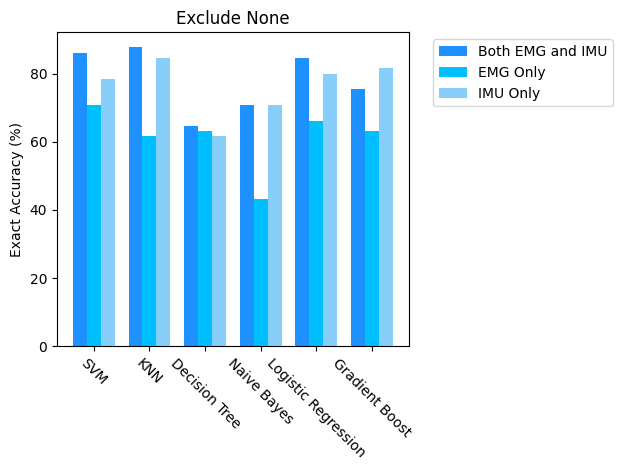

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


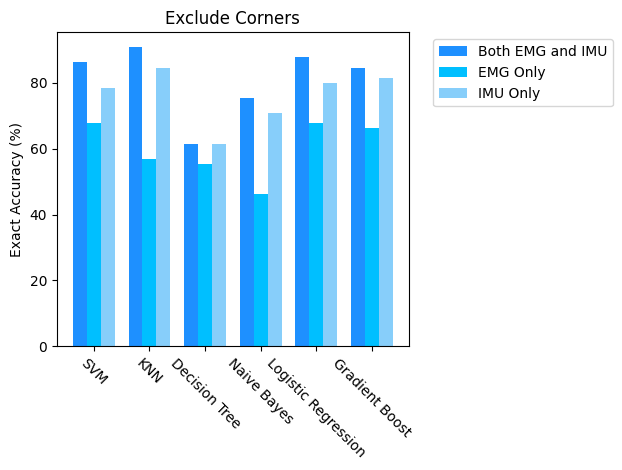

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


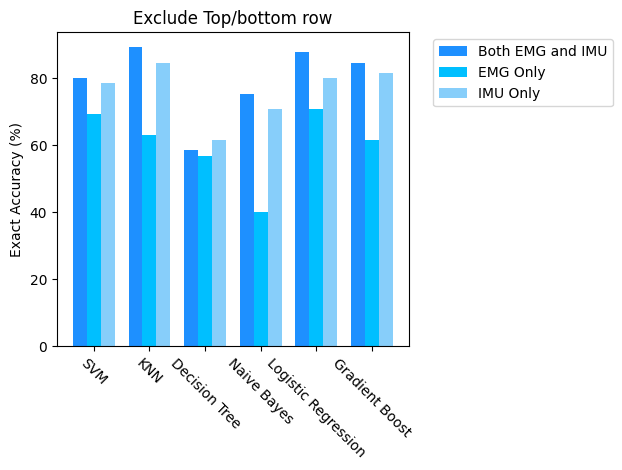

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


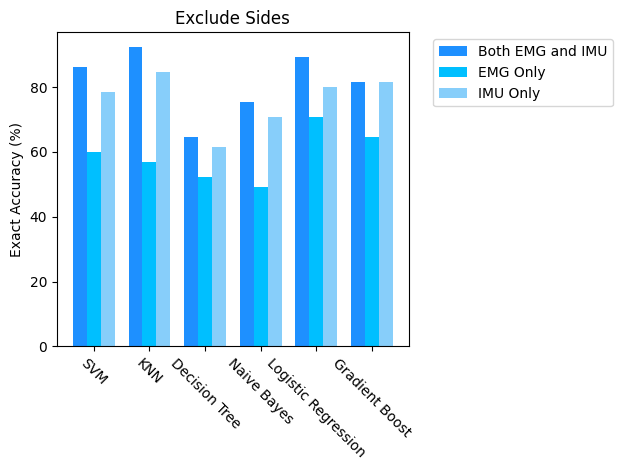

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


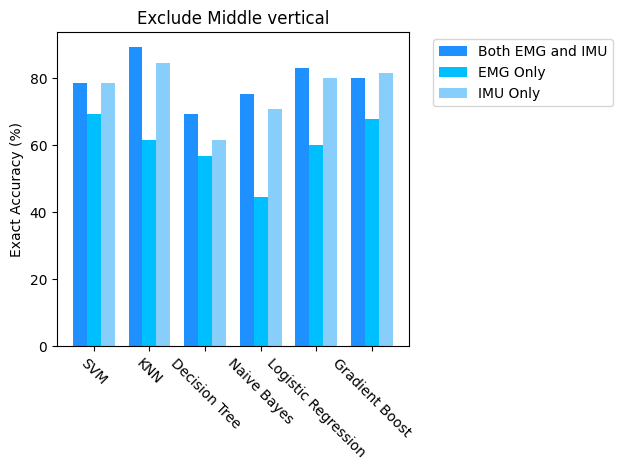

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


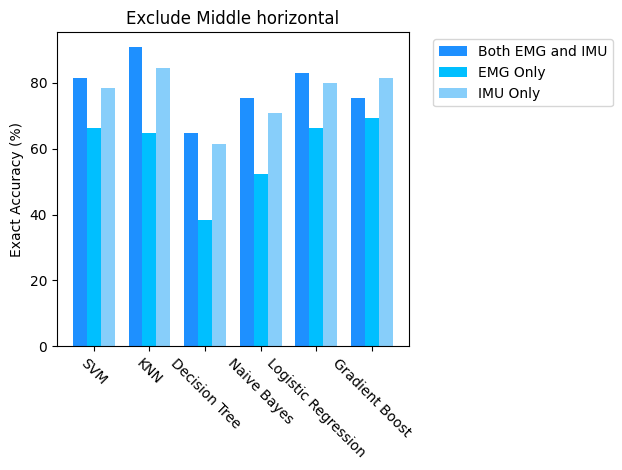

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


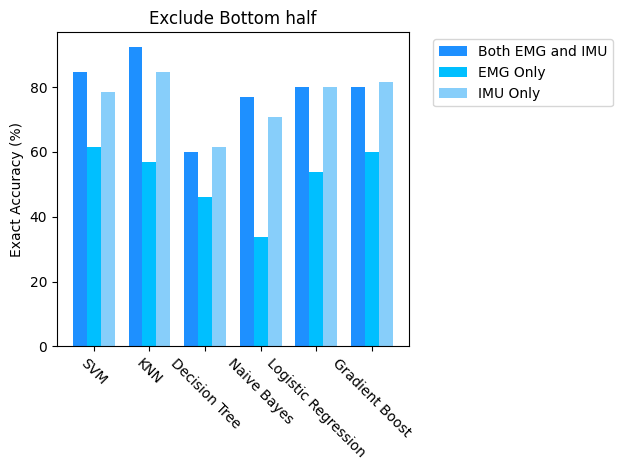

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


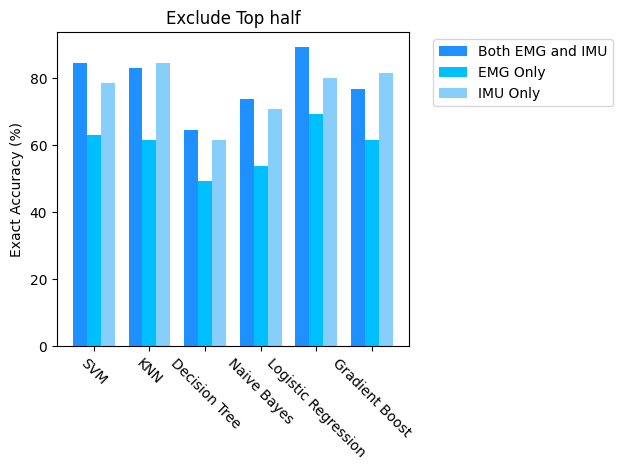

C:\Users\chloe\AppData\Local\Temp\ipykernel_42812\1051360365.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


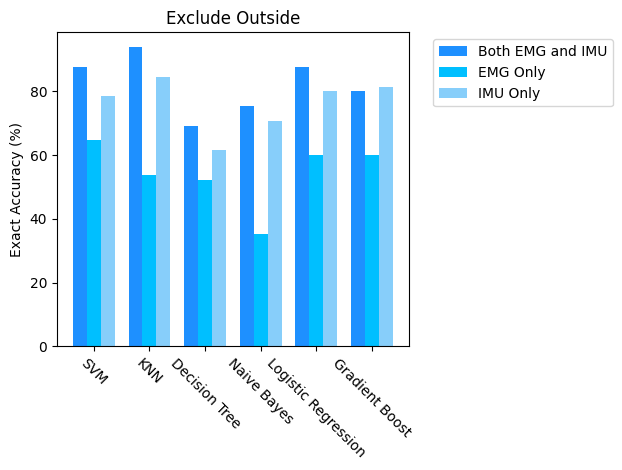

In [10]:
# EMG Channel configuration
# 9, 2, 4, 15
# 1, 12, 5, 7
# 10, 3, 14, 16
# 11, 13, 6, 8

configurations = [['None', []],
                  ['Corners', [9, 15, 11, 8]],
                  ['Top/bottom row', [9, 2, 4, 15, 11, 13, 6, 8]],
                  ['Sides', [9, 1, 10, 11, 15, 7, 16, 8]],
                  ['Middle vertical', [2, 4, 12, 5, 3, 14, 13, 6]],
                  ['Middle horizontal', [1, 12, 5, 7, 10, 3, 14, 16]],
                  ['Bottom half', [10, 3, 14, 16, 11, 13, 6, 8]],
                  ['Top half', [9, 2, 4, 15, 1, 12, 5, 7]],
                  ['Outside', [9, 2, 4, 15, 7, 16, 8, 6, 13, 11, 10, 1]]]

config_acc = []

for config in configurations:
    acc = configuration_models(config[0], config[1])
    acc_model_pairs = list(zip(acc, model_names))
    greatest_acc, model = max(acc_model_pairs, key=lambda x: x[0])
    config_acc.append([config[0], greatest_acc, model])

In [11]:
config_acc.sort(key=lambda x: x[1], reverse=True)

sorted_acc = pd.DataFrame(config_acc, columns=['Excluded Channels', 'Highest Accuracy', 'Model'])
sorted_acc

,Excluded Channels,Highest Accuracy,Model
0,Outside,93.846154,KNN
1,Sides,92.307692,KNN
2,Bottom half,92.307692,KNN
3,Corners,90.769231,KNN
4,Middle horizontal,90.769231,KNN
5,Top/bottom row,89.230769,KNN
6,Middle vertical,89.230769,KNN
7,Top half,89.230769,Logistic Regression
8,None,87.692308,KNN
